# Imports

In [2]:
fig_num = 0

In [3]:
import pandas as pd
pd.set_option("max_colwidth", 160)
pd.set_option("display.max_columns", None)

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")



def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)
  return data


In [18]:
def lemmatization(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  df = dataframe.copy()
  lemmas = []
  for doc in nlp.pipe(df[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct and not token.is_stop and not token.like_num and len(token) > 1) ]))
  df[text_column+"_lemmatized"] = lemmas
  return df


# this function by analogy to ENG debates for polarity / valence measures
def get_valence_scores(data, content_lemmatized_column, affective_database, db_words = "Word"):
  '''Parameters: 
  dataframe: dataframe with your data,

  content_lemmatized_column: str - name of a column in dataframe where word-lemmas are listed, 
  
  affective_database_path: str - path to a file with affective database, 
  
  db_words: str - name of a column in affective database where words are listed, 
  '''  
  dataframe = data.copy()
  #affective_database = load_data(affective_database_path)

  emotion_values = ["Valence_standardized"]
  used_cols = [db_words] + emotion_values

  affective_database_valence = affective_database[used_cols]
  affective_database_valence.set_index(db_words, inplace=True)
  affective_database_valence_words = affective_database[db_words].tolist()

  neg_valence_scores = []
  pos_valence_scores = []

  overall_scores_pos = []
  overall_scores_neg = []
  overall_scores = []

  for row in dataframe[content_lemmatized_column]:
    words_emo = row.split()
    if len(row) > 0:
      scores = affective_database_valence.loc[words_emo]

      neg_score = scores.where(scores["Valence_standardized"].round(1) < -0.5).count()[0]
      neg_valence_scores.append(neg_score)

      pos_score = scores.where(scores["Valence_standardized"].round(1) > 1).count()[0]
      pos_valence_scores.append(pos_score)

      neg_score2 = abs(scores.where(scores["Valence_standardized"] < -0.5).mean()[0])
      if not (neg_score2 >= 0 and neg_score2 <= 4):
        neg_score2 = 0

      pos_score2 = scores.where(scores["Valence_standardized"] > 1).mean()[0]
      if not (pos_score2 >= 0 and pos_score2 <= 4):
        pos_score2 = 0

      overall_scores_pos.append(pos_score2)
      overall_scores_neg.append(neg_score2)
      if pos_score2 > neg_score2:
        overall_scores.append(pos_score2)
      elif pos_score2 < neg_score2:
        overall_scores.append(neg_score2 * -1)
      elif pos_score2 == neg_score2:
        overall_scores.append(0)

    else:
      neg_score=pos_score=polarity_score=score_overall = np.NaN
      overall_scores.append(score_overall)
      overall_scores_pos.append(score_overall)
      overall_scores_neg.append(score_overall)
      neg_valence_scores.append(neg_score)
      pos_valence_scores.append(pos_score)

  dataframe["content_valence_score"] = overall_scores
  dataframe["content_valence_score_pos"] = overall_scores_pos
  dataframe["content_valence_score_neg"] = overall_scores_neg
  dataframe["content_valence_negative"] = neg_valence_scores
  dataframe["content_valence_positive"] = pos_valence_scores
  return dataframe  


In [3]:
!python -m spacy download pl_core_news_md --quiet


[+] Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

import spacy

# load SPACY model
nlp = spacy.load('pl_core_news_md')

In [5]:
def clean_text(df, text_column):
  import re
  new_texts = []
  for text in df[text_column]:
    text_list = str(text).lower().split(" ")
    new_string_list = []
    for word in text_list:
      if 'http' in word:
        word = "url"
      elif ('@' in word) and (len(word) > 1):
        word = "user"
      if (len(word) > 1) and not (word.isnumeric()):
        new_string_list.append(word)
    new_string = " ".join(new_string_list)
    new_string = re.sub("\d+", " ", new_string)
    new_string = new_string.replace('\n', ' ')
    new_string = new_string.replace('\r', ' ')
    new_string = new_string.strip()
    new_texts.append(new_string)
  df[text_column] = new_texts
  return df

# Merge single datasets

In [148]:
df1 = pd.read_csv(r"C:\Users\user1\Downloads\gazeta2_cln.csv", index_col=0)
df1.shape

(205701, 21)

In [149]:
df2 = pd.read_csv(r"C:\Users\user1\Downloads\interia2_cln.csv", index_col=0)
df2.shape

(647289, 22)

In [197]:
df3 = pd.read_csv(r"C:\Users\user1\Downloads\interia1_cln.csv", index_col=0)
df3.shape

(1599878, 22)

In [1]:
df = pd.concat( [df1, df2, df3], axis=0, ignore_index=True )
df.head(2)

In [214]:
df = df_all.reset_index(drop=True)
df.to_csv(r"C:\Users\user1\Downloads\wnpid_all.csv")
df.shape

(2452868, 24)

In [263]:
df['month'].value_counts()

3     628300
6     396646
7     386781
5     319533
10    223087
8     218733
9     209304
11     67698
1       1500
2       1286
Name: month, dtype: int64

# Data single

In [6]:
df = pd.read_csv(r"C:\Users\user1\Downloads\interia1.csv", index_col=0)
df.shape

(3041841, 8)

In [8]:
df = df.drop_duplicates(['content'])
df.shape

(2452007, 8)

In [9]:
df['month'] = pd.to_datetime(df.datetime).dt.month
df = df[df.month.isin([1, 2, 3, 5, 6, 7, 8, 9, 10, 11])]
#df['month'] = np.where(df['month'].isin([5, 6]), 6, df['month'])
df['month'].value_counts()

3     733426
6     455743
5     364219
7     286624
8       6210
9       4854
10      1601
Name: month, dtype: int64

In [10]:
df.shape

(1852677, 9)

In [11]:
df['content'] = df['content'].apply(str)
df = df[df.content.str.split().map(len) > 2]
df.shape

(1769872, 9)

In [12]:
df = clean_text(df, 'content')
df = df[df.content.str.split().map(len) > 2]
df.shape

(1752708, 9)

In [13]:
df = df.drop_duplicates(['content'])
df.shape

(1733609, 9)

In [15]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [2]:
df = lemmatization(df, 'content')

In [23]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [151]:
affdb = load_data(r"C:\Users\user1\Downloads\valence_db.xlsx")
print(affdb.shape)
affdb.head(2)

(10806, 4)


,Word,Database,Valence,Valence_standardized
0,Maczkowy,Sentimenti,0.566481,0.419659
1,abderyta,Sentimenti,0.402546,-0.553951


In [152]:
affdb2 = affdb[ (affdb.Valence_standardized < -0.5) | (affdb.Valence_standardized > 1) ]
affdb2.shape

(4960, 4)

In [153]:
affdb2['Word'] = affdb2['Word'].str.lower()
aff_words = affdb2['Word'].values
aff_words[:5]

array(['abderyta', 'aberracyjny', 'absmak', 'absurd', 'absurdalny'],
      dtype=object)

In [27]:
#emotive_words = [word for word in lemmas_list if word in affective_database_valence_words]

df['valence_words'] = df['content_lemmatized'].apply(lambda x: " ".join( [w for w in str(x).split() if w in aff_words] ))
df['valence_words'].iloc[500:503]

523    nieszczęśliwy miłość gej
524                         gej
525               pobić partner
Name: valence_words, dtype: object

In [28]:
df = df[df.content_lemmatized.str.split().map(len) > 2]
df.shape

(1599878, 11)

In [31]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [154]:
neg_words = set(affdb[ (affdb.Valence_standardized < -0.5) ]['Word'].values)
pos_words = set(affdb[ (affdb.Valence_standardized > 1) ]['Word'].values)

neg_affdb = affdb[ (affdb.Valence_standardized < -0.5)].set_index('Word')
pos_affdb = affdb[ (affdb.Valence_standardized > 1) ].set_index('Word')
pos_affdb.head(2)

,Database,Valence,Valence_standardized
Word,,,
adopcja,Sentimenti,0.829397,1.98111
akademicki,Sentimenti,0.666014,1.01078


In [252]:
#df_null_val = df[df['valence_words'].isna()]
#df_full_val = df[ ~(df['valence_words'].isna())]

df_null_val = df_all[df_all['valence_words'] == 'nan']
df_full_val = df_all[df_all['valence_words'] != 'nan']

df_null_val.shape, df_full_val.shape

((196854, 24), (2256014, 24))

In [256]:
# 1st method --  faster to compute


df_full_val['valence_words'] = df_full_val['valence_words'].apply(str)
df_null_val['valence_words'] = df_null_val['valence_words'].apply(str)

#df_full_val['neg_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( set(str(x).split()).intersection(neg_words) ))
#df_full_val['pos_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( set(str(x).split()).intersection(pos_words) ))
df_full_val['neg_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( [w for w in str(x).split() if w in neg_words]) )
df_full_val['pos_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( [w for w in str(x).split() if w in pos_words]) )


df_full_val['content_valence_negative'] = df_full_val['neg_valence_words'].str.split().map(len)
df_full_val['content_valence_positive'] = df_full_val['pos_valence_words'].str.split().map(len)
df_full_val['content_valence_negative'] = np.where(df_full_val.valence_words.str.split().map(len) > 0, df_full_val['content_valence_negative'], np.nan)
df_full_val['content_valence_positive'] = np.where(df_full_val.valence_words.str.split().map(len) > 0, df_full_val['content_valence_positive'], np.nan)


df_full_val['content_valence_score_neg'] = df_full_val.neg_valence_words.apply(lambda x: np.abs(neg_affdb.loc[ str(x).split() ]['Valence_standardized'].mean()))
df_full_val['content_valence_score_pos'] = df_full_val.pos_valence_words.apply(lambda x: np.abs(pos_affdb.loc[ str(x).split() ]['Valence_standardized'].mean()))
df_full_val['content_valence_score_neg'] = df_full_val['content_valence_score_neg'].fillna(0)
df_full_val['content_valence_score_pos'] = df_full_val['content_valence_score_pos'].fillna(0)

df_full_val['content_valence_score'] = np.where(df_full_val['content_valence_score_neg'] > df_full_val['content_valence_score_pos'], df_full_val['content_valence_score_neg']*-1, 0)
df_full_val['content_valence_score'] = np.where(df_full_val['content_valence_score_neg'] < df_full_val['content_valence_score_pos'], df_full_val['content_valence_score_pos'], df_full_val['content_valence_score'])


In [31]:
# 2nd method: with a dedicated function -- slower bc of the "for loop"


cols_literal2 = {'valence_words'} 

for col in cols_literal2:
  print(col)
  df_full_val = get_valence_scores(df_full_val, content_lemmatized_column = col, 
                        affective_database = affdb2)

df_full_val.head(3)

valence_words


,nestedReplies,votesRank,votesCount,replies,author,id,parentId,content,timestamp,month,content_lemmatized,valence_words,content_valence_score,content_valence_score_pos,content_valence_score_neg,content_valence_negative,content_valence_positive
1370,0,4,4,0,mawik_net,59304307,59304103,"user ze względu na pandemię strach było jechać do włoch lub grecji gdyby był wybór, to na pewno nie byłby bałtyk. lipcu było zimno.",2020-11-17 18:27:57,11,user wzgląd pandemia strach jechać włochy grecja wybór pewno być by Bałtyk lipiec zimno,strach włochy zimno,-1.256616,1.121130,1.256616,2,1
1371,0,3,3,0,eselk,59304524,59304103,"user samo mówią, że nie jadają maku, między gorzowem, szczecinem latem nie ma jak zatankować.",2020-11-17 18:42:55,11,user samo mówić jadać mak gorzowo szczecinem lato zatankować,lato,1.944089,1.944089,0.000000,0,1
1372,0,3,3,0,ladychapel,59304157,0,"jezeli baltyk to tylko neringa, gdzie kilometr na prawo kilometr na lewo nikogo innego",2020-11-17 18:13:22,11,baltyk neringa kilometr prawo kilometra lewo nikt inny,lewo nikt,-1.636472,0.000000,1.636472,2,0


In [259]:
df = pd.concat( [df_full_val, df_null_val], axis=0 )
df.shape

(2452868, 24)

In [313]:
df = df.reset_index(drop=True)
df.shape

(2452868, 24)

In [315]:
df['neg_percent'] = (df.content_valence_negative / df.content_lemmatized.str.split().map(len)) * 100
df['pos_percent'] = (df.content_valence_positive / df.content_lemmatized.str.split().map(len)) * 100

In [316]:
df.loc[:, ['neg_percent', 'pos_percent']].describe().round(3)

,neg_percent,pos_percent
count,1835419.000,1835419.000
mean,11.103,10.569
std,11.037,10.868
min,0.000,0.000
25%,0.000,0.000
50%,9.091,8.333
75%,16.667,16.667
max,100.000,100.000


In [268]:
df.groupby(['month'])[['pos_percent', 'neg_percent', 'content_valence_score_pos',  'content_valence_score_neg']].mean()

,pos_percent,neg_percent,content_valence_score_pos,content_valence_score_neg
month,,,,
1,9.359413,12.080457,1.000722,1.142976
2,9.858131,13.159801,1.013896,1.169615
3,8.430677,9.313789,0.736084,0.779956
5,8.198359,8.477688,0.752868,0.736647
6,8.157385,7.788242,0.746694,0.667642
7,8.882049,8.551185,0.824045,0.754341
8,10.598550,11.628228,1.002443,1.024599
9,10.447130,11.956535,0.996122,1.041797
10,10.379787,11.988601,0.999556,1.055360


In [317]:
df['content_valence_score_neg'] = df['content_valence_score_neg']*10
df['content_valence_score_pos'] = df['content_valence_score_pos']*10

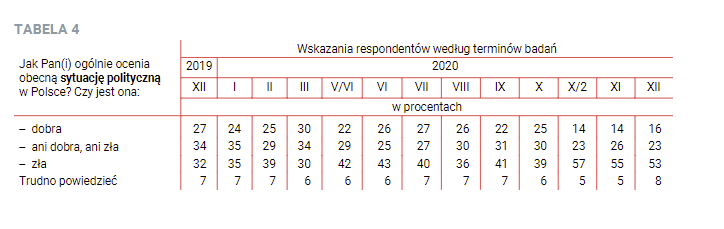

In [271]:
sond_dob = {
    1:24, 2:25, 
    3:30, 5:22, 6:24,
    7:27, 8:26, 9:22, 10:25, 11:14}
sond_zla = {
    1:35, 2:39,
    3:30, 5:42, 6:42.5,    
    7:40, 8:36, 9:41, 10:39, 11:45}

In [58]:
df['month_resp_dob'] = df['month'].map(sond_dob)

df['month_resp_zla'] = df['month'].map(sond_zla)

In [59]:
df['month_resp'] = df['month_resp_dob'] - df['month_resp_zla']

In [60]:
df.groupby(['month'])[['month_resp_dob', 'month_resp_zla', 'month_resp']].mean()

,month_resp_dob,month_resp_zla,month_resp
month,,,
3,30.0,30.0,0.0
5,22.0,42.0,-20.0
6,24.0,42.5,-18.5
7,27.0,40.0,-13.0
8,26.0,36.0,-10.0
9,22.0,41.0,-19.0
10,25.0,39.0,-14.0


In [61]:
df['month_resp'] = np.where(df.month == 3, -1, df['month_resp'])
df.groupby(['month'])[['month_resp_dob', 'month_resp_zla', 'month_resp']].mean()

,month_resp_dob,month_resp_zla,month_resp
month,,,
3,30.0,30.0,-1.0
5,22.0,42.0,-20.0
6,24.0,42.5,-18.5
7,27.0,40.0,-13.0
8,26.0,36.0,-10.0
9,22.0,41.0,-19.0
10,25.0,39.0,-14.0


In [318]:
df['content_valence_score'] = df['content_valence_score']*10

In [273]:
df.groupby(['month'], as_index=False)[['month_resp', 'content_valence_score']].mean()

,month,month_resp,content_valence_score
0,1,-11.0,-2.029454
1,2,-14.0,-2.491996
2,3,-1.0,-0.794682
3,5,-20.0,0.060919
4,6,-18.5,1.066267
5,7,-13.0,0.870777
6,8,-10.0,-0.481356
7,9,-19.0,-0.866147
8,10,-14.0,-0.924634
9,11,-31.0,0.446932


In [ ]:
df = pd.concat( [df1, df2, df], axis=0, ignore_index=True )

In [274]:
df.shape

(2452868, 24)

## Proportion valence

In [319]:
df['valence_pos'] = np.where(df.content_valence_negative < df.content_valence_positive, 1, 0)
df['valence_neg'] = np.where(df.content_valence_positive < df.content_valence_negative, 1, 0)

In [320]:
df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean()

,month,valence_neg,valence_pos
0,1,0.434667,0.280667
1,2,0.443235,0.271384
2,3,0.338396,0.290672
3,5,0.322849,0.303005
4,6,0.295999,0.314542
5,7,0.298399,0.315243
6,8,0.344004,0.303557
7,9,0.356448,0.292541
8,10,0.361016,0.291070
9,11,0.337248,0.301368


In [321]:
df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean().iloc[:, 1:].values.flatten()

array([0.43466667, 0.28066667, 0.44323484, 0.27138414, 0.33839567,
       0.29067165, 0.32284928, 0.3030047 , 0.29599946, 0.31454244,
       0.29839884, 0.31524299, 0.34400388, 0.30355731, 0.35644804,
       0.29254099, 0.36101611, 0.2910703 , 0.33724778, 0.30136784])

In [279]:
list(sond_dob.keys())

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

In [322]:
df[['prop_neg', 'prop_pos']] = np.nan

props = df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean().iloc[:, 1:].values.flatten()
i = 0    
for m in list(sond_dob.keys()):
  for v in ['valence_neg', 'valence_pos']:
    ids = df[ (df['month'] == m) & (df[v] == 1) ].index
    df.loc[ids, "prop"+str(v)[-4:]] = props[i] * 100
    i += 1

In [325]:
df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean()

,month,month_resp_dob,prop_pos
0,1,24.0,28.066667
1,2,25.0,27.138414
2,3,30.0,29.067165
3,5,22.0,30.300470
4,6,24.0,31.454244
5,7,27.0,31.524299
6,8,26.0,30.355731
7,9,22.0,29.254099
8,10,25.0,29.107030
9,11,14.0,30.136784


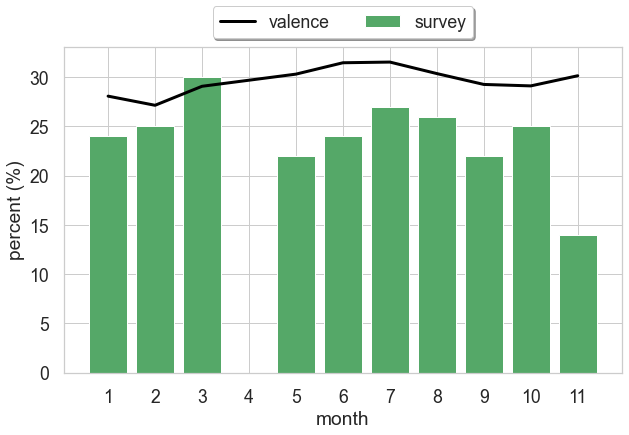

In [326]:
# full

mon = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 0].values
one = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 1].values
two = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 2].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='g', label = 'survey')
plt.xlabel('month')
plt.ylabel('percent (%)')
plt.xticks(np.arange(1, 12, 1))
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

#plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

In [328]:
df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean()

,month,month_resp_zla,prop_neg
0,1,35.0,43.466667
1,2,39.0,44.323484
2,3,30.0,33.839567
3,5,42.0,32.284928
4,6,42.5,29.599946
5,7,40.0,29.839884
6,8,36.0,34.400388
7,9,41.0,35.644804
8,10,39.0,36.101611
9,11,45.0,33.724778


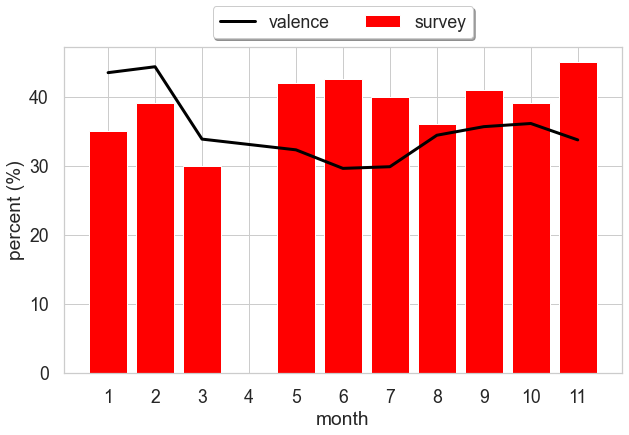

In [329]:
# full

mon = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 0].values
one = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 1].values
two = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 2].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='red', label = 'survey')
plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

#plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

# Other stats

In [79]:
from scipy.stats import pearsonr
from sklearn import metrics

In [330]:
df_n = df.dropna(subset=['prop_neg'], axis=0)
print(df_n.shape)

(803039, 24)


In [331]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # full data
# dupl 6.684
# uniq 6.88

6.88

In [231]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # interia 2 uniq

3.276

In [301]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # interia 2 duplicates

4.127

In [332]:
df_n['mae'] = np.abs(df_n['month_resp_zla'] - df_n['prop_neg'])
df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean()

,month,month_resp_zla,prop_neg,mae
0,1,35.0,43.466667,8.466667
1,2,39.0,44.323484,5.323484
2,3,30.0,33.839567,3.839567
3,5,42.0,32.284928,9.715072
4,6,42.5,29.599946,12.900054
5,7,40.0,29.839884,10.160116
6,8,36.0,34.400388,1.599612
7,9,41.0,35.644804,5.355196
8,10,39.0,36.101611,2.898389
9,11,45.0,33.724778,11.275222


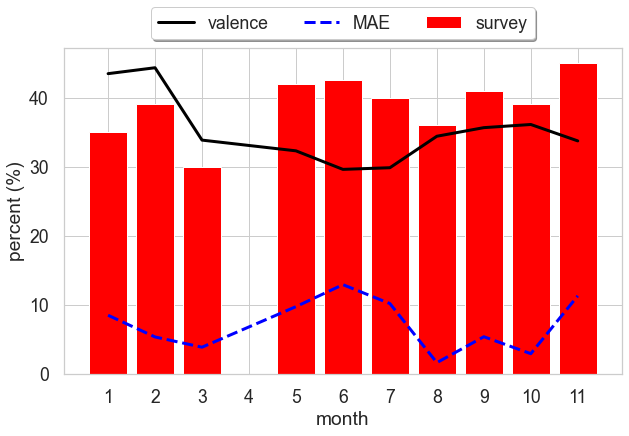

In [333]:
# full

mon = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 0].values
one = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 1].values
two = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 2].values
mae_n = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='red', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

In [334]:
df_p = df.dropna(subset=['prop_pos'], axis=0)
print(df_p.shape)

(739875, 24)


In [335]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # full data
# dupl 5.285
# uniq 5.119

5.119

In [235]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # interia 2 uniq

4.063

In [305]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # interia 2 duplicates

5.43

In [336]:
df_p['mae'] = np.abs(df_p['month_resp_dob'] - df_p['prop_pos'])
df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean()

,month,month_resp_dob,prop_pos,mae
0,1,24.0,28.066667,4.066667
1,2,25.0,27.138414,2.138414
2,3,30.0,29.067165,0.932835
3,5,22.0,30.300470,8.300470
4,6,24.0,31.454244,7.454244
5,7,27.0,31.524299,4.524299
6,8,26.0,30.355731,4.355731
7,9,22.0,29.254099,7.254099
8,10,25.0,29.107030,4.107030
9,11,14.0,30.136784,16.136784


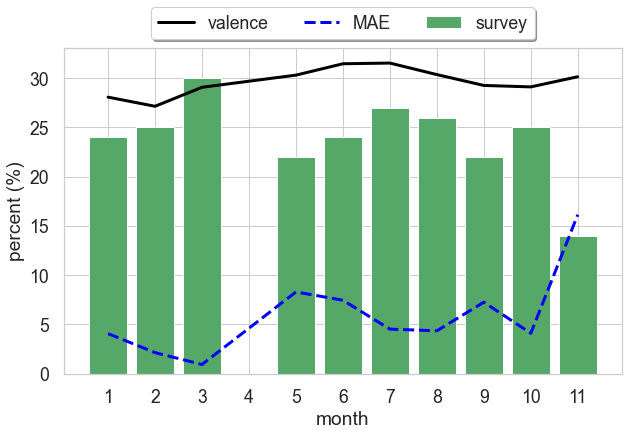

In [337]:
# full

mon = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 0].values
one = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 1].values
two = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 2].values
mae_n = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')
plt.figure(figsize = (10,6))

ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='g', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

# Sentiment BERT-model

In [4]:
from transformers import pipeline

In [5]:
model_path = "eevvgg/PaReS-sentimenTw-political-PL"

sentiment_task = pipeline(task = "sentiment-analysis", model = model_path, tokenizer = model_path)

Downloading:   0%|          | 0.00/889 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/529M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
df = pd.read_csv(r"C:\Users\user1\Downloads\wnpid_all.csv", index_col=0)
df.shape

(2452868, 24)

In [13]:
sequence = df.iloc[:100000].content.to_list()

In [16]:
sequence = [s if len(str(s)) < 510 else str(s)[:510] for s in sequence]

In [17]:
sequence[5005:5009]

['szczegolnie ma panowac czyli pałować) te zgraje frajerow podpuszczanych przez opozycje na ulicac zobaczymy tydzien lub dwa jakie wyniki beda zakazen poprzez wrzeszczacy sobie geby tłum',
 'user sprawdziłaś tę wiadomość, czy tak sobie napisałaś aby napisać?<br> czy jeśli jakaś twoja kumpela, załóżmy, że jeszcze liceum powiedziałaby ci, że kk przekazał na szpitale miliard złotych to też niezwłocznie być się podzieliła taka informacja bez sprawdzenia?',
 'user będzie bięcej czy chyba będzie więcej?<br> czy jeśli innych krajach scenariusze będą tragiczniejsze to będzie oznaczało, że naszym życiu śmierci decydowali jednak kompetentni fachowcy nie będziesz miał problemu napisaniem tym?',
 'user dodał, mamy polski scenariusz epidemii, który jest chyba jeszcze bardziej tragiczny, niż ten początku epidemii we włoszech"<br> to znaczy, że mamy czy chyba mamy?<br> no na czym polega ten chyba tragiczniejszy scenariusz?']

In [ ]:
result = sentiment_task(sequence)
len(result)

In [3]:
labels = [i['label'] for i in result]

In [ ]:
df['sentimentBERT'] = labels